In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from tqdm import tqdm

from ChromatinFibers import (
    plot_footprints,
    convert_to_footprints,
    fetch_chromosome_sequence,
    ChromatinFiber,
)
from Plotter import SequencePlotter
from pycorrelate import pcorrelate

In [3]:
chromosome = fetch_chromosome_sequence(r".genomes/sacCer3/sacCer3.fa", chromosome="II")
length = 10_000
locus_start = np.random.randint(0, len(chromosome) - length)
locus_sequence = chromosome[locus_start : locus_start + length]
fiber = ChromatinFiber(sequence=locus_sequence, start=locus_start)
fiber.fetch_orfs_by_range(start=locus_start, end=locus_start + length, chromosome="II")

ic(fiber.sequence)

filename_out = "figures/simulated_yeast_fiber.png"

ic| str(filename.parent): '.genomes\\sacCer3'


Selected chromosome: chrII  len=813184


ic| fiber.sequence: 'TATGATGGTTGTTCTCTGTTGTTTCGGTACTATCAACGGTTATTATCATTGGACGCAAAAATATCGTTGGCGGCTAAATACGGGGGTGGCAAAGAGTTTGCGCCCGCGTTCAGTGGATACAAACAGTATAAGTAGGACAGGCGACATCTTTAGTAAATAGTACAGGAAAAGGAGGACTTATCAGGGTATCACACAAACAATGGTACAGAACAATGAATCGGTTTTTTTCGTTGAATGCGACTCTTATAAGGAGAGCCCTTCCACTTCACCAATACGCTTGGACGACCTGGATGGAAATGACGCTGTGTCGGATCAGGGTTTAGCTTTCGACGGGGACGTAGGAATTACATCACAAGCTCGAGTAAGAAATCCTCGAGCTCAAATCTTCGAGGATAGTAATACTGACGTAGTATTGCATTTGGATGATCTTGATATGGTCCCACTAAATACGAAGTTCGATATGCAGATGGAGATGGGTTCACCCATGGCGATGCCGGCAGAAACGCCACCTCCTGTCGAACCTTTAAAAACAAAAGATCTAGCATATTCATCCTTGGCTCACCTTCCTAGCTATTTCTTTGAGCAAACACATTTCCGCATAGACCGCAAATGCCTGTTGGAAATGTCTAAGTTAAGGCGAAATTATCTAACTATAAGTAAACAAGATGCTTTGTCATGTCCGCAGCTTCATTCAAGAGTGGCTGGGGGTTATCTTAAACCTGTAAAAGAAAAATTATTTGGAATACGTCACTTTCTTGATCTAGAGGAAAGTAATACTGTAAACCTCCTCCAGGATGGTAATTATATGACGGAATTGTTCAACAGTCAGATTAATATCCCCACTTTTAAAGAATTTAGGGAAGATTTTGAATGGTGCTTGAAAATTATAAGAGATAGAAGCCTATCAAGGTTTAGCGAAAAAAGATTACAATATCTTGTAAATAAGTTTCCAGTTTTTCAACACCTACATTCCAAGGAA

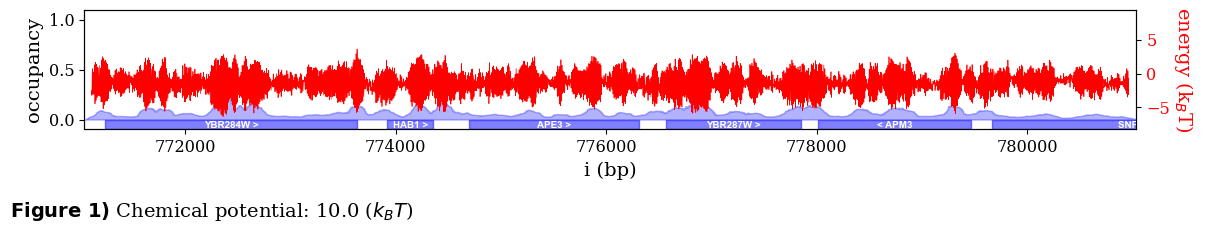

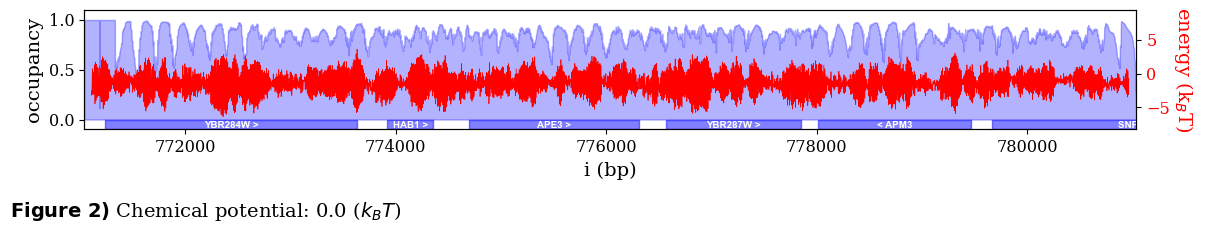

In [7]:
plotter = SequencePlotter()

mus = np.linspace(10.0, 0.0, 2)
for mu in mus:
    fiber.calc_energy_landscape(amplitude=0.05, period=9.7, chemical_potential=mu)
    plotter.plot(fiber, energy=True, orfs=True)
    # plotter.add_label(fig_label="B")
    plotter.add_caption(f"Chemical potential: {mu} ($k_BT$)", filename=filename_out)



Sampling fibers and calculating methylation: 100%|██████████| 50/50 [00:01<00:00, 25.60it/s]


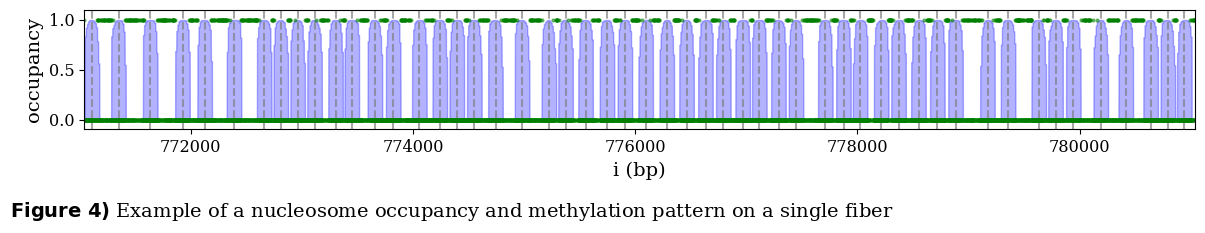

In [9]:
n = 50
methylated = []
for i in tqdm(range(n), desc="Sampling fibers and calculating methylation"):
    dyads = fiber.sample_fiber_configuration()
    methylation = fiber.calc_methylation(
        dyads, efficiency=0.4, e_contact=-0.8, steric_exclusion=0
    )
    methylated.append(methylation.methylated)

plotter.plot(
    fiber,
    dyads=dyads,
    occupancy=methylation.protected,
    methylation=methylation.methylated,
)

plotter.add_caption(
    "Example of a nucleosome occupancy and methylation pattern on a single fiber"
, filename=filename_out)


MemoryError: Unable to allocate 261. MiB for an array with shape (1278, 6697, 4) and data type float64

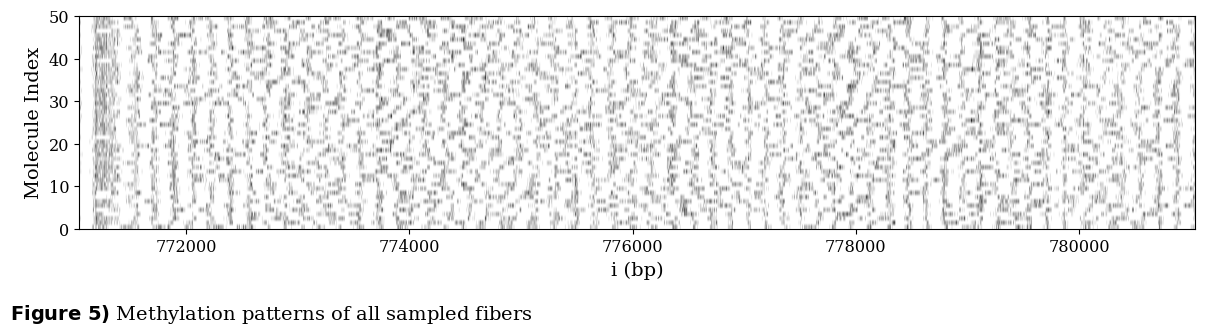

In [11]:
plt.figure(figsize=(12, 3))
plt.imshow(
    np.asarray(methylated) == 1,
    aspect="auto",
    cmap="Greys",
    extent=(
        fiber.index[0].astype(float),
        fiber.index[-1].astype(float),
        0,
        len(methylated),
    ),
)
plt.xlabel("i (bp)")
plt.ylabel("Molecule Index")
plt.tight_layout()
plotter.add_caption("Methylation patterns of all sampled fibers", filename=filename_out)


Plotting footprints: 50it [00:03, 14.60it/s]


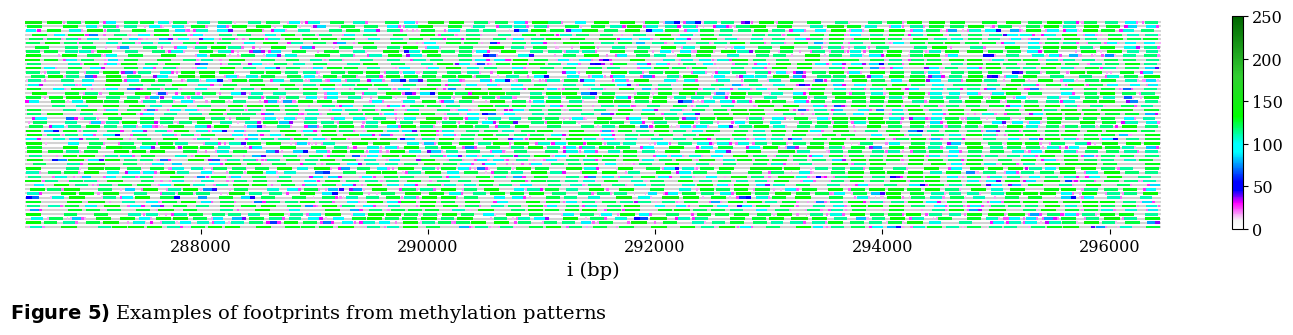

In [6]:
footprints = convert_to_footprints(methylated, fiber.index, minimal_footprint=15)

plot_footprints(footprints, fiber.index, n_max=50)

plotter.add_caption("Examples of footprints from methylation patterns", filename=filename_out)


Calculating correlation:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating correlation: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


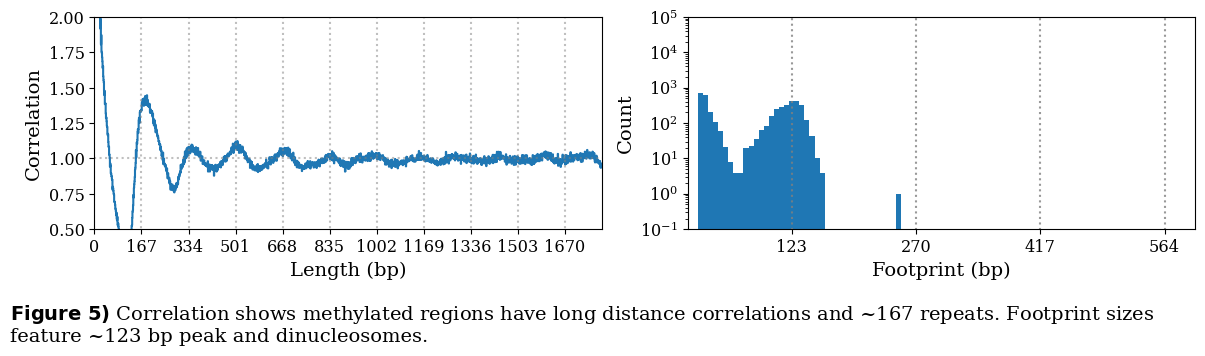

In [12]:
def analyze_footprints(methylated: np.ndarray, show = False) -> None:

    bins = np.arange(0, 1801, 1).astype(float)
    correlation = np.zeros_like(bins[:-1])

    for m in tqdm(methylated, desc="Calculating correlation"):
        t = fiber.index.astype(float)[np.where(m == 1)]
        correlation += pcorrelate(t, t, bins, normalize=True)

    footprints = convert_to_footprints(methylated, fiber.index, minimal_footprint=15)

    if show:
        vlines = np.arange(0, np.max(bins).astype(int), 167)

        plt.figure(figsize=(12, 3))
        # make two figures next to each other
        plt.subplot(1, 2, 1)
        plt.plot(bins[:-1], correlation / len(methylated), drawstyle="steps-post")

        plt.xticks(vlines, labels=[str(x) for x in vlines])
        plt.vlines(vlines, ymin=0, ymax=2, colors="gray", linestyles="dotted", alpha=0.5)
        plt.hlines(1, xmin=0, xmax=np.max(bins), colors="gray", linestyles="dotted", alpha=0.5)
        plt.xlim(0, np.max(bins))
        plt.xlabel("Length (bp)")
        plt.ylabel("Correlation")
        plt.ylim(0.5, 2)

        # go to second figure
        plt.subplot(1, 2, 2)
        maxwidth = 600
        plt.xlim(0, maxwidth)
        plt.hist(footprints["width"].values, bins=100, range=(0, maxwidth))
        plt.xlabel("Footprint (bp)")
        plt.ylabel("Count")
        plt.ylim(1e-1, 1e5)
        xticks = np.arange(0, maxwidth, 147) - 24
        plt.xticks(xticks, labels=[str(x) for x in xticks])
        plt.vlines(
            xticks,
            ymin=0,
            ymax=plt.gca().get_ylim()[1],
            colors="gray",
            linestyles="dotted",
            alpha=0.8,
        )
        plt.xlim(0, maxwidth)
        plt.yscale("log")

        plt.tight_layout()


    return correlation, footprints

correlation, footprints = analyze_footprints(methylated, show=True)
plotter.add_caption(
    "Correlation shows methylated regions have long distance correlations and ~167 repeats. "
    + "Footprint sizes feature ~123 bp peak and dinucleosomes. "
    , filename=filename_out
)


ic| str(filename.parent): '.genomes\\sacCer3'


Selected chromosome: chrII  len=813184


Calculating correlation: 100%|██████████| 5000/5000 [04:00<00:00, 20.76it/s]


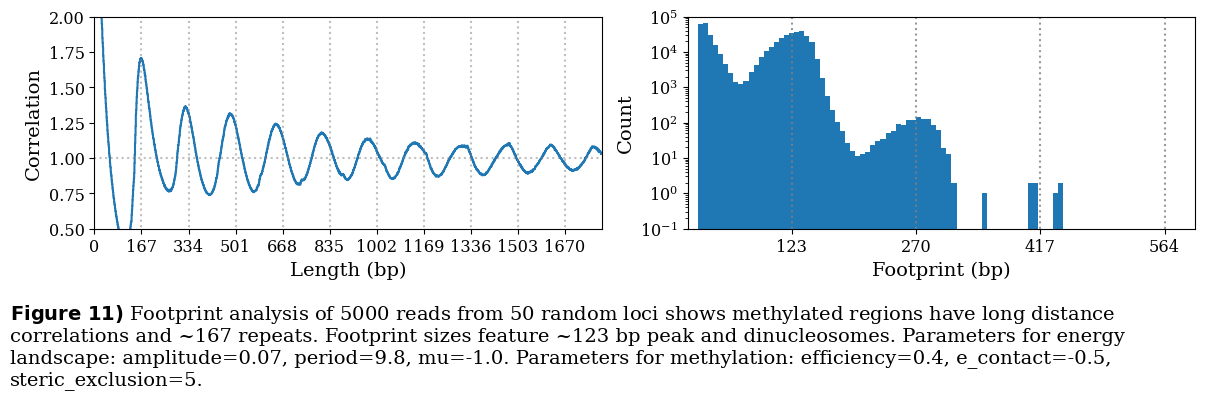

In [12]:


chromosome = fetch_chromosome_sequence(r".genomes/sacCer3/sacCer3.fa", chromosome="II")

# Parameters for sampling the genomic loci
length = 10_000
n_loci = 50
n_reads = 100

# Parameters for nucleosome energy landscape
amplitude = 0.07
period = 9.8
mu = -1.0

# Parameters for methylation
efficiency = 0.4
e_contact = -0.5
steric_exclusion = 5

methylated = []


for _ in tqdm(range(n_loci), desc="Processing multiple loci"):
    locus_start = np.random.randint(0, len(chromosome) - length)
    locus_sequence = chromosome[locus_start : locus_start + length]
    fiber = ChromatinFiber(sequence=locus_sequence, start=locus_start)
    fiber.calc_energy_landscape(amplitude=amplitude, period=period, chemical_potential=mu)
    
    for i in range(n_reads):
        dyads = fiber.sample_fiber_configuration()
        methylation = fiber.calc_methylation(
            dyads, efficiency=efficiency, e_contact=e_contact, steric_exclusion=steric_exclusion
        )
        methylated.append(methylation.methylated)
        
correlation, footprints = analyze_footprints(methylated, show=True)

plotter.add_caption(
    f"Footprint analysis of {len(methylated)} reads from {n_loci} random loci shows methylated regions have long distance correlations and ~167 repeats. "
    + "Footprint sizes feature ~123 bp peak and dinucleosomes. "
    + f"Parameters for energy landscape: amplitude={amplitude}, period={period}, mu={mu}. "
    + f"Parameters for methylation: efficiency={efficiency}, e_contact={e_contact}, steric_exclusion={steric_exclusion}.",
    filename=filename_out
)
